In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import time
from sklearn import metrics

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
order_products_prior.head() # info includes: order_id,product from this order, ordering, reorder or not

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
orders.head() # users info

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
aisles.shape # 134: more detailed than 'departments' Departments: 20

(134, 2)

In [7]:
orders['user_id'].nunique()

206209

There are 206,209 unique customer in our dataset, for this task I will only consider 5000 customers to save computational power.

In [8]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
orders = orders[orders['user_id']<=5000]

In [10]:
orders['user_id'].nunique()

5000

In [11]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# Problem Statement

In this notebook, I'll segment customers based on their purchse records.

In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
# merge orders dataset with product dataset
_mt = pd.merge(orders,order_products_prior,on='order_id',how='left')
#merge with products
_mt = pd.merge(_mt,products,on='product_id',how='left')
#merge with aisle
_mt = pd.merge(_mt,aisles,on='aisle_id',how='left')

In [14]:
_mt.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods


In [15]:
_mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766750 entries, 0 to 766749
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                766750 non-null  int64  
 1   user_id                 766750 non-null  int64  
 2   eval_set                766750 non-null  object 
 3   order_number            766750 non-null  int64  
 4   order_dow               766750 non-null  int64  
 5   order_hour_of_day       766750 non-null  int64  
 6   days_since_prior_order  717518 non-null  float64
 7   product_id              761750 non-null  float64
 8   add_to_cart_order       761750 non-null  float64
 9   reordered               761750 non-null  float64
 10  product_name            761750 non-null  object 
 11  aisle_id                761750 non-null  float64
 12  department_id           761750 non-null  float64
 13  aisle                   761750 non-null  object 
dtypes: float64(6), int64

In [16]:
_mt['product_name'].value_counts()[0:10]

Banana                    10625
Bag of Organic Bananas     8921
Organic Strawberries       6384
Organic Baby Spinach       5570
Organic Hass Avocado       5253
Organic Avocado            3939
Large Lemon                3797
Organic Raspberries        3560
Strawberries               3414
Limes                      3348
Name: product_name, dtype: int64

In [17]:
print('There are {} unique products are bought by our 10,000 customers from {} unique aisles.'
      .format((len(_mt['product_name'].unique())), len(_mt['aisle_id'].unique())))


There are 28855 unique products are bought by our 10,000 customers from 135 unique aisles.


In [18]:
# all purchase items by each customer
cust_prod = pd.crosstab(_mt['user_id'], _mt['department_id'])
cust_prod.head()

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,13,0,0,0,...,0,1,3,0,13,2,0,22,0,0
2,17,0,2,36,0,3,9,0,0,0,...,1,11,3,1,48,0,0,42,21,0
3,6,0,0,38,0,0,3,0,4,0,...,0,4,0,0,21,1,0,9,2,0
4,3,0,2,2,2,0,3,0,0,0,...,0,0,0,1,0,2,0,1,2,0
5,2,0,0,19,0,2,0,0,1,0,...,0,2,0,1,8,0,0,1,1,0


This crosstable shows that how many purchases a user made from different departments(e.g. User1 bought 5 items from department 4 and 13 times from department 7 and 1 item from 13, 3 items from 14, 13 time 16 and 2 items form 17 and 22 items from 19).

In [19]:
cust_prod.shape

(5000, 21)

# K-Means

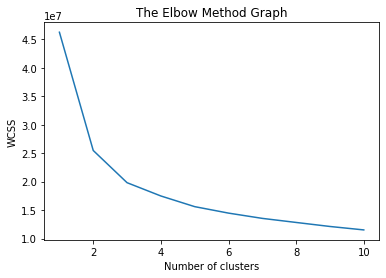

In [20]:
# optimal numbers of clusters
wcss = []
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
    kmeans.fit(cust_prod)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

According to Elbow graph, I determine the cluster number equals to 5, which means I will segment customers into 5 groups according to what they purchased.

In [21]:

kmeans_cluster = KMeans(n_clusters=5, random_state=123)
# Fit model
%timeit kmeans_cluster.fit(cust_prod)
y_pred = kmeans_cluster.predict(cust_prod)

182 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


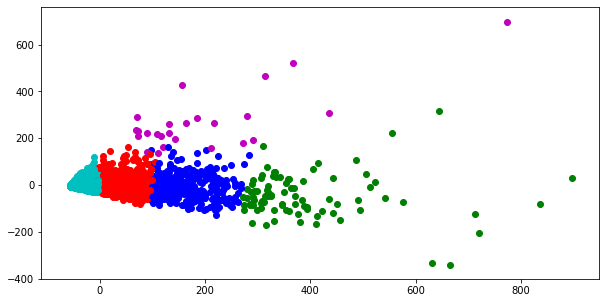

In [22]:
#demensionality deduction with pca
pca = PCA(n_components=2).fit_transform(cust_prod)
plt.figure(figsize=(10,5))
colours = ['r','g','b','c','m']
for i in range(pca.shape[0]):
    plt.scatter(pca[i, 0], pca[i, 1],
             color=colours[y_pred[i]])

In [23]:
#demensionality deduction with umap
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(cust_prod)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 11.130897045135498 seconds


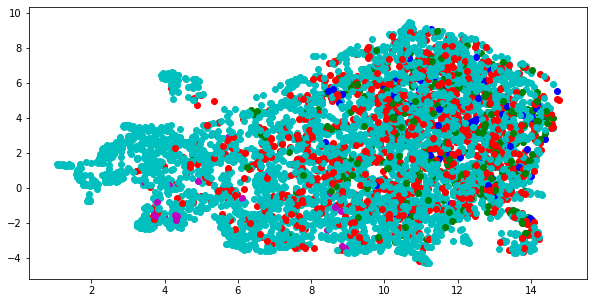

In [24]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m"]
for i in range(umap_results.shape[0]):
    plt.scatter(umap_results[i, 0], umap_results[i, 1],
             color=colours[y_pred[i]])
plt.show()

Seems like the umap is not an appropriate way to reduce demensionality in our case in order to observe how the clusters are grouped. 

In [25]:
# evaluation
print('The silhouette coefficient for 5 kmeans cluster is {}'.
      format(metrics.silhouette_score(cust_prod,y_pred,metric='euclidean')))

The silhouette coefficient for 5 kmeans cluster is 0.48174978010107733


# Hierarchical clustering

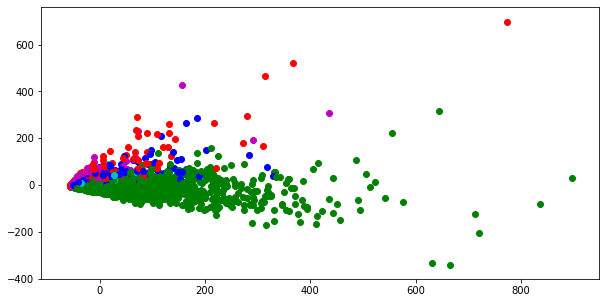

In [26]:
from sklearn.cluster import AgglomerativeClustering
agg_cluster_com = AgglomerativeClustering(n_clusters=5,linkage='complete',affinity='cosine')
complete_clusters = agg_cluster_com.fit_predict(cust_prod)
plt.figure(figsize=(10,5))
colours = ['r','g','b','c','m']
for i in range(pca.shape[0]):
    plt.scatter(pca[i, 0], pca[i, 1],
             color=colours[complete_clusters[i]])

In [27]:
# evaluation
print('The silhouette coefficient for 5 hierarchical cluster is {}'.
      format(metrics.silhouette_score(cust_prod,complete_clusters,metric='euclidean')))

The silhouette coefficient for 5 hierarchical cluster is -0.25384469919172387


# GMM

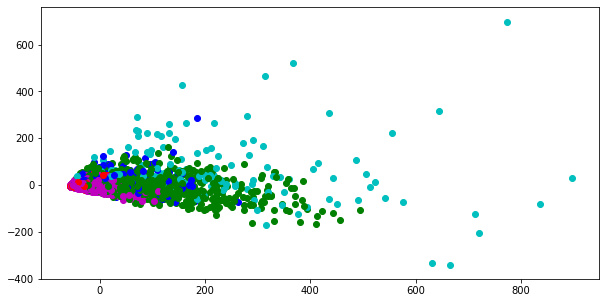

In [28]:
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=5, random_state=33)
gmm_clusters = gmm_cluster.fit_predict(cust_prod)
plt.figure(figsize=(10,5))
for i in range(pca.shape[0]):
    plt.scatter(pca[i, 0], pca[i, 1],
             color=colours[gmm_clusters[i]])

In [29]:
# evaluation
print('The silhouette coefficient for 5 GMM cluster is {}'.
      format(metrics.silhouette_score(cust_prod,gmm_clusters,metric='euclidean')))

The silhouette coefficient for 5 GMM cluster is -0.06915930782460475


In [30]:
_mt.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods


In [31]:
reorder_cluster = _mt[['user_id','reordered','add_to_cart_order']].groupby('user_id').mean()

In [32]:
reorder_cluster['cluster'] = y_pred
reorder_cluster

,reordered,add_to_cart_order,cluster
user_id,,,
1,0.694915,3.627119,3
2,0.476923,8.553846,0
3,0.625000,4.443182,3
4,0.055556,2.777778,3
5,0.378378,5.513514,3
...,...,...,...
4996,0.238095,4.904762,3
4997,0.563910,3.338346,3
4998,0.727273,2.227273,3


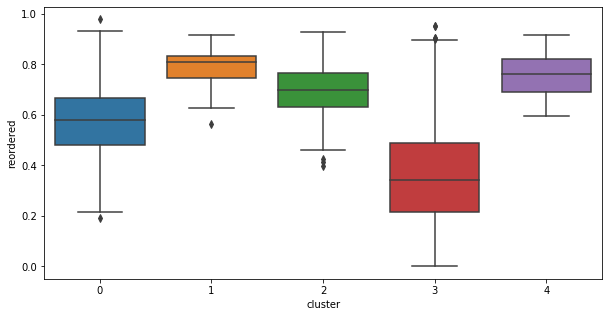

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'cluster', y = 'reordered',data = reorder_cluster)

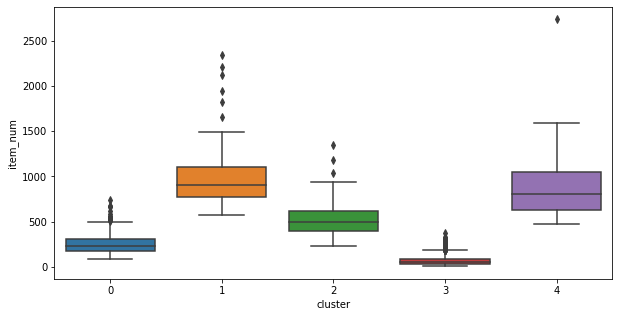

In [34]:
plt.figure(figsize=(10,5))
num_order = _mt[['user_id','order_id']].groupby(['user_id']).count().reset_index()
num_order['cluster'] = y_pred
num_order.rename(columns={'order_id':'item_num'},inplace=True)
num_order.head()
sns.boxplot(x = 'cluster', y = 'item_num',data = num_order)

As we can see here, the customers from different clusters grouped by departments show a different pattern in terms of how reorder ratio and total intems bought from Instacart. 

Cluster 0 and cluster 3 have relatively low level reorder ratio and total purchase, while 1 and 4 cluster has relatively high level reorder ratio and item purchase. Is it a coincidence?

In [35]:
cust_prod['cluster'] = y_pred
cust_prod.head()

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,13,0,0,0,...,1,3,0,13,2,0,22,0,0,3
2,17,0,2,36,0,3,9,0,0,0,...,11,3,1,48,0,0,42,21,0,0
3,6,0,0,38,0,0,3,0,4,0,...,4,0,0,21,1,0,9,2,0,3
4,3,0,2,2,2,0,3,0,0,0,...,0,0,1,0,2,0,1,2,0,3
5,2,0,0,19,0,2,0,0,1,0,...,2,0,1,8,0,0,1,1,0,3


In [36]:
cust_prod = cust_prod.append(cust_prod.sum(axis=0),ignore_index=True)

In [37]:
cluster0 = cust_prod[cust_prod['cluster']==0]
cluster1 = cust_prod[cust_prod['cluster']==1]
cluster2 = cust_prod[cust_prod['cluster']==2]
cluster3 = cust_prod[cust_prod['cluster']==3]
cluster4 = cust_prod[cust_prod['cluster']==4]
print('Cluster 0 has {} customers, cluster 1 has {} customers, cluster 2 has {} customers, cluster 3 has {} customers, cluster 4 has {} customers'.format(len(cluster0),len(cluster1), len(cluster2), len(cluster3), len(cluster4)))

Cluster 0 has 999 customers, cluster 1 has 85 customers, cluster 2 has 338 customers, cluster 3 has 3553 customers, cluster 4 has 25 customers


In [38]:
cluster0.drop('cluster',axis=1,inplace=True)
cluster1.drop('cluster',axis=1,inplace=True)
cluster2.drop('cluster',axis=1,inplace=True)
cluster3.drop('cluster',axis=1,inplace=True)
cluster4.drop('cluster',axis=1,inplace=True)

/Users/lilijiaxin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


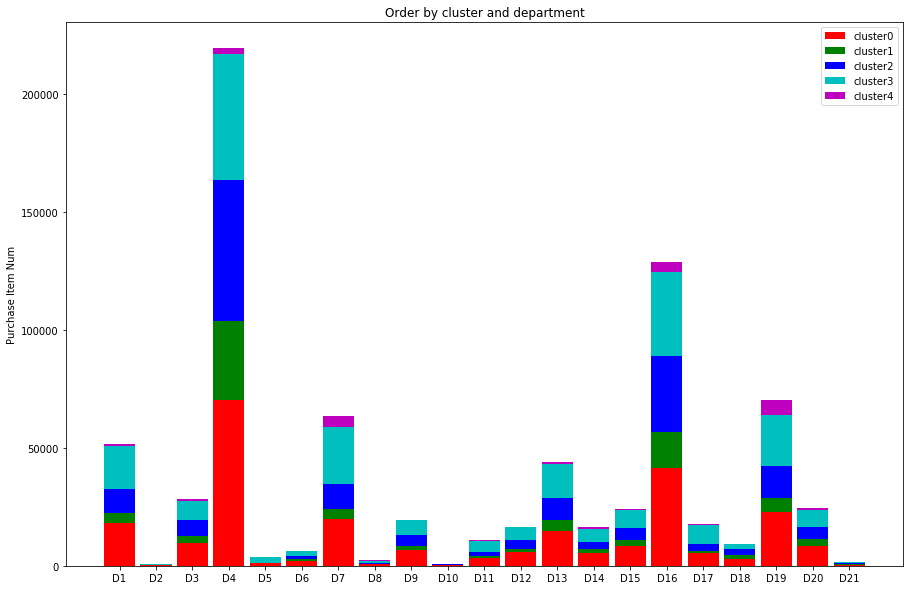

In [39]:
plt.figure(figsize=(15,10))
N = 21
cluster0_sum = cluster0.sum(axis=0)
cluster1_sum = cluster1.sum(axis=0)
cluster2_sum = cluster2.sum(axis=0)
cluster3_sum = cluster3.sum(axis=0)
cluster4_sum = cluster4.sum(axis=0)
ind = np.arange(N)    # the x locations for the groups
width = 0.85       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, cluster0_sum, width,color='r')
p2 = plt.bar(ind, cluster1_sum, width, color='g',
             bottom=cluster0_sum)
p3 = plt.bar(ind, cluster2_sum, width, color='b',
             bottom=cluster1_sum+cluster0_sum)
p4 = plt.bar(ind, cluster3_sum, width,color='c',
             bottom=cluster2_sum+cluster1_sum+cluster0_sum)
p5 = plt.bar(ind, cluster4_sum, width,color='m',
             bottom=cluster3_sum+cluster2_sum+cluster1_sum+cluster0_sum)
plt.ylabel('Purchase Item Num')
plt.title('Order by cluster and department')
plt.xticks(ind, ('D1', 'D2', 'D3', 'D4', 'D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','D16','D17','D18','D19','D20','D21'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0],p3[0],p4[0],p5[0]), ('cluster0', 'cluster1','cluster2','cluster3','cluster4'))

plt.show()

Most order purchase items came from Department D4, D16 and D19.

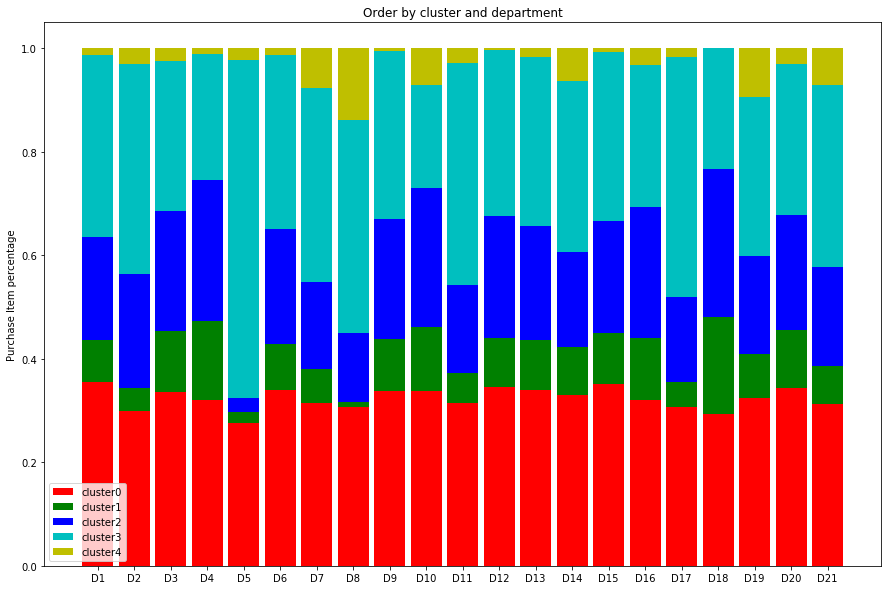

In [40]:
plt.figure(figsize=(15,10))
N = 21
total = cust_prod.iloc[5000,0:21]
cluster0_percentage = cluster0.sum(axis=0)/total
cluster1_percentage = cluster1.sum(axis=0)/total
cluster2_percentage = cluster2.sum(axis=0)/total
cluster3_percentage = cluster3.sum(axis=0)/total
cluster4_percentage = cluster4.sum(axis=0)/total
ind = np.arange(N)    # the x locations for the groups
width = 0.85       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, cluster0_percentage, width,color='r')
p2 = plt.bar(ind, cluster1_percentage, width, color='g',
             bottom=cluster0_percentage)
p3 = plt.bar(ind, cluster2_percentage, width, color='b',
            bottom=cluster1_percentage+cluster0_percentage)
p4 = plt.bar(ind, cluster3_percentage, width,color='c',
             bottom=cluster2_percentage+cluster1_percentage+cluster0_percentage)
p5 = plt.bar(ind, cluster4_percentage, width,color='y',
             bottom=cluster3_percentage+cluster2_percentage+cluster1_percentage+cluster0_percentage)
plt.ylabel('Purchase Item percentage')
plt.title('Order by cluster and department')
plt.xticks(ind, ('D1', 'D2', 'D3', 'D4', 'D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','D16','D17','D18','D19','D20','D21'))
#plt.yticks(np.arange(0, 1, 0.01))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0]), ('cluster0', 'cluster1','cluster2','cluster3','cluster4'))

plt.show()

Investigate on what kind of items customers from cluster0 and cluster3 like to buy(cluster0 and cluster3 have the lowest reorder rate and number purchase per customer):
The cluster0 and cluster3 dominate departments are: D5(alcohol)and D17(household). We can tell that customers who like to buy alcohol or household are potentially the people who are less likly to reorder or buy less items from Instacart. 